<a href="https://colab.research.google.com/github/interngithub2020/RF_modulation_classification/blob/master/constellation_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction and aims of this notebook

This notebook aims to assess the effectiveness of constellation diagrams for modulation classification when they are input into an AlexNet-like architecture. I explore different resolutions and colourations of constellation images and conclude that higher resolution helps but colouration does not.

Background: Classifying by coloured constellation images have shown great accuracy in: [Data-Driven Deep Learning for Automatic Modulation Recognition in Cognitive Radios](https://ieeexplore.ieee.org/document/8645696). From human eye, we are able to recognise the modulation from the I/Q constellation at high SNR, and presumably a CNN would be able to do the same as it has been proven to work well on image classification. 

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")
root_path = "/content/gdrive/My Drive/mod_rec/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/
Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
#%reset
%tensorflow_version 1.x
from sklearn.externals import joblib
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, BatchNormalization, LSTM, Conv1D, MaxPooling1D, Conv2D, Input, Concatenate, Add, PReLU
from keras.layers.convolutional import Convolution1D ,Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.initializers import glorot_uniform, Constant
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from scipy.interpolate import UnivariateSpline
from keras.utils import to_categorical
from sklearn import preprocessing
from keras.optimizers import Adam
from keras import regularizers


plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

TensorFlow 1.x selected.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Training parameters and helper functions

Here I set training parameters and helper functions used in common across all models. 

## Variables used for training the models



In [ ]:
EPOCHS = 100
NUM_CLASSES = 8
BATCH_SIZE = 64 #constellation images
PATIENCE = 4 #constellation takes quite long to train

## Functions for data conversion

In [ ]:
#Normalisation is very important
def iq2ampphase(inphase, quad):
    amplitude = np.sqrt(np.square(inphase) + np.square(quad))
    amp_norm = np.linalg.norm(amplitude) #L2 norm
    amplitude = amplitude/amp_norm #normalise
    phase = np.arctan(np.divide(quad, inphase))
    phase = 2.*(phase - np.min(phase))/np.ptp(phase)-1 #rescale phase to range [-1, 1]
    return amplitude, phase

#convert array of multiple iq samples into array of multiple ampphase samples
def arr_iq2ap(X):
  X_ap = []
  for k in range(X.shape[0]):
    I = X[k][0,:]
    Q = X[k][1,:]
    amp, phase = iq2ampphase(I, Q)
    ap = np.array([amp, phase])
    X_ap.append(ap)
  X_ap = np.array(X_ap)
  return X_ap

In [ ]:
def arr2img(arr, chnum):
  norm = plt.Normalize(vmin=arr.min(), vmax=arr.max())
  if chnum == 1:
      cmap = plt.cm.gray
      image4d = cmap(norm(arr)) #RGBA
      img = image4d[:,:,0] #All RGBA channels identical
      
  elif chnum == 3:
      cmap = plt.cm.hot #or can choose any other colormap
      image4d = cmap(norm(arr)) #RGBA
      img = image4d[:,:,:3] #ignore A channel
    
  return img

## Functions for generating and plotting confusion matrices


In [ ]:
def generate_confusion_matrix(model, X,y, one_hot_transformer, batch_size):
    """
      y is the one hot encoded label vector passed to the model.evaluate
    """
    mod_to_idx = {mod:idx for idx,mod in enumerate(one_hot_transformer.classes_)} # use this to map modulation name to index
    y_hat = model.predict(X, batch_size)
    y_hat_onehot = np.zeros_like(y_hat)
    y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
    y_hat_mod = one_hot_transformer.inverse_transform(y_hat_onehot) # transform predictions to strings
    y_mod = one_hot_transformer.inverse_transform(y) # transform ground truth back to strings
    confusion_mat = np.zeros([NUM_CLASSES,NUM_CLASSES])

    acc = np.mean(y_mod == y_hat_mod)
    # fill in the confusion matrix
    for i in range(y.shape[0]):
        
        true_idx = mod_to_idx[y_mod[i]]
        pred_idx = mod_to_idx[y_hat_mod[i]]          
        confusion_mat[pred_idx,true_idx] += 1

    # normalize the matrix column wise
    for i in range(NUM_CLASSES):
        if np.sum(confusion_mat[:,i]) > 0:
          confusion_mat[:,i] /= np.sum(confusion_mat[:,i])
    
    return confusion_mat,acc

 
import seaborn as sns
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells
  
  plt.title(title)
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels)
  plt.tight_layout()
  plt.ylabel('Predicted label')
  plt.xlabel('True label')

## Label encoder class of functions

In [ ]:
#created my own LabelBinarizer class so can encode both 2-class and multiclass cases
class MyLabelBinarizer(preprocessing.LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y

    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

## ModelEvaluater Class of functions for training and evaluation
(1) formatting label data into one-hot format,  

(2) fitting model with training data,

(3) evaluating model using accuracy plots and confusion matrices

During fitting, Model Checkpoints are set so that weights files are automatically saved when validation loss decreases. There is also earlystopping, for which the default patience is 10 epochs. 

During print_summary(), the model is evaluated on the test set and prints out the confusion matrices for different SNRs and a graph showing accuracy over different SNRs.

Example on using ModelEvaluater class: 

    fc_model = build_fc_net(X_test.shape[1],X_teat.shape[2])
    fc_model_evaluater = ModelEvaluater(fc_model, X_train, y_train, X_val, y_val, X_test, y_test, labels_test, BATCH_SIZE,  'fc-net' )
    fc_model_evaluater.fit(EPOCHS, patience=10)
    fc_model_evaluater.print_summary()


In [ ]:
class ModelEvaluater:
  def __init__(self, model, X_train, y_train, X_val, y_val, X_test, y_test,
               labels_test, batch_size, model_name, channels_first=True, feature_type=1):
    if channels_first:
      self.X_train = X_train
      self.X_val = X_val
      self.X_test = X_test
    else:
      self.X_train = X_train.reshape([X_train.shape[0], X_train.shape[2], X_train.shape[1]])
      self.X_val = X_val.reshape([X_val.shape[0], X_val.shape[2], X_val.shape[1]])
      self.X_test = X_test.reshape([X_test.shape[0], X_test.shape[2], X_test.shape[1]])
    
    self.feature_type = feature_type
      
    self.model = model
    self.y_train = y_train
    self.y_val = y_val
    self.y_test = y_test
    self.labels_test = labels_test
    self.model_name = model_name
    self._checkpoint_callback = ModelCheckpoint(filepath=root_path + '%s-weights-{epoch}.hdf5' % self.model_name,
                                                verbose=1, save_best_only=True)
    self._train_accs = []
    self._val_accs = []
    self._snr_accs = []
    
    self.batch_size = batch_size
    
    # get the modulation types into an array
    self.mod_types = np.unique(labels_test[:,0])
  
    # fit a label binarizer 
    self.mod_to_onehot = MyLabelBinarizer()
    self.mod_to_onehot.fit(self.mod_types)

    # transform the y values to one-hot encoding
    self.y_train = self.mod_to_onehot.transform(y_train)
    self.y_val = self.mod_to_onehot.transform(y_val)
    self.y_test = self.mod_to_onehot.transform(y_test)
  
    print('y_train %s' %(y_train.shape))
    print('y_val %s' %(y_val.shape))
    print('y_test %s' %(y_test.shape))
    

    
  def fit(self, epochs, patience=10):
    curr_X, curr_y = self.X_train, self.y_train
    val_X, val_y = self.X_val, self.y_val
    callbacks = [self._checkpoint_callback, EarlyStopping(patience=patience)]
   
     # train the model
    model_info = self.model.fit(curr_X, curr_y,
                                batch_size=self.batch_size,
                                epochs=epochs,
                                verbose=1,
                                validation_data=(val_X, val_y),
                                callbacks=callbacks)

    self._train_accs.extend(model_info.history['accuracy'])
    self._val_accs.extend(model_info.history['val_accuracy'])



  def print_summary(self):
    # plot validation accuracy vs training accuracy
    plt.plot(np.arange(len(self._train_accs)), self._train_accs, '-o', label='training accuracy')
    plt.plot(np.arange(len(self._val_accs)), self._val_accs, '-o', label='validation accuracy')
    plt.legend()
    plt.xlabel('epochs')
    plt.title('%s -validation vs training accuracy' %(self.model_name))
    display(plt.show())

    #plot confusion matrix for all, low, med and high SNR
    snr_ranges = [(-20, 20),(-10, 5), (6, 20)]
    for snr_rng in snr_ranges:
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where((labels_test >= snr_rng[0]) & (labels_test <=snr_rng[1]))
      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]
      conf_mat, acc = generate_confusion_matrix(self.model, X_snr, y_snr, self.mod_to_onehot, self.batch_size)
      plot_confusion_matrix(conf_mat, labels=self.mod_to_onehot.classes_, 
                            title='%s- Confusion Matrix (SNR in range %s) - acc=%s' %(self.model_name, snr_rng, acc*100))
      plt.show()

    # get accuracy per snr
    snr_accs = {}
    snrs = np.unique(np.unique(self.labels_test,axis=0)[:,1]).astype('int32')
    for snr in sorted(snrs):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where(labels_test == snr)

      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]

      #calculate acc for each snr
      mod_to_idx = {mod:idx for idx,mod in enumerate(self.mod_to_onehot.classes_)} # use this to map modulation name to index
      y_hat = self.model.predict(X_snr, self.batch_size)
      y_hat_onehot = np.zeros_like(y_hat)
      y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
      y_hat_mod = self.mod_to_onehot.inverse_transform(y_hat_onehot) # transform predictions to strings
      y_mod = self.mod_to_onehot.inverse_transform(y_snr) # transform ground truth back to strings

      acc = np.mean(y_mod == y_hat_mod)
      snr_accs[snr] = acc

    # plot the accuracy against the snr
    plt.plot(list(snr_accs.keys()),list(snr_accs.values()))
    plt.xlabel("Signal to Noise Ratio")
    plt.ylabel("Classification Accuracy")
    plt.xticks(list(snr_accs.keys()))
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.grid(True)
    plt.show()


  def accpersnr_model(self):
    snr_accs = {}
    snrs = np.unique(np.unique(self.labels_test,axis=0)[:,1]).astype('int32')
    for snr in sorted(snrs):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where(labels_test == snr)

      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]

      #calculate acc for each snr
      mod_to_idx = {mod:idx for idx,mod in enumerate(self.mod_to_onehot.classes_)} # use this to map modulation name to index
      y_hat = self.model.predict(X_snr, self.batch_size)
      y_hat_onehot = np.zeros_like(y_hat)
      y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
      y_hat_mod = self.mod_to_onehot.inverse_transform(y_hat_onehot) # transform predictions to strings
      y_mod = self.mod_to_onehot.inverse_transform(y_snr) # transform ground truth back to strings

      acc = np.mean(y_mod == y_hat_mod)
      snr_accs[snr] = acc

    return snr_accs

# Loading and formatting of data 

In a python script, I divided the radioML dataset into a train-val-test split of 0.67 - 0.13 - 0.2, and stored them in 'rml_trainvaltest.hdf5'. They have already been shuffled, so simply load them as below.

More information about the source:
The 2016.10A radioML dataset (download here https://www.deepsig.ai/datasets) is a python dictionary with keys (mod, SNR) and values being an array of samples of 2x128 time-series I/Q data. It contains 11 types of modulations of varying SNR, and also contains some simulated channel effects. Refer to [Radio Machine Learning Dataset Generation with GNU Radio](https://pubs.gnuradio.org/index.php/grcon/article/view/11) for more information on the dataset.

In [ ]:
from sklearn.externals import joblib
data = joblib.load(root_path + 'data/rml_trainvaltest.hdf5')

In [ ]:
#quick understanding of data
print(data.keys())
print('Train val test size: ', data['train']['X'].shape, data['val']['X'].shape, data['test']['X'].shape)
print('Check if data is shuffled: ', data['val']['labels'][:10])

uniq, counts = np.unique(data['train']['labels'][:,1], return_counts = True)
print('Check snr range: ', uniq)
print('Check distribution of samples across SNR: ', counts)

uniq, counts = np.unique(data['train']['labels'][:,0], return_counts = True)
print('Check modulation types: ', uniq)
print('Check distribution of samples across modulation types: ', counts)

dict_keys(['val', 'train', 'test'])
Train val test size:  (107200, 2, 128) (20800, 2, 128) (32000, 2, 128)
Check if data is shuffled:  [['d4PAM' '16']
 ['a16QAM' '0']
 ['cGFSK' '-20']
 ['dBPSK' '4']
 ['d4PAM' '-20']
 ['cCPFSK' '-2']
 ['dBPSK' '-4']
 ['d4PAM' '-16']
 ['a16QAM' '-20']
 ['a64QAM' '2']]
Check snr range:  ['-10' '-12' '-14' '-16' '-18' '-2' '-20' '-4' '-6' '-8' '0' '10' '12'
 '14' '16' '18' '2' '4' '6' '8']
Check distribution of samples across SNR:  [5422 5363 5335 5362 5333 5279 5310 5330 5316 5390 5436 5326 5334 5445
 5393 5385 5319 5399 5372 5351]
Check modulation types:  ['a16QAM' 'a64QAM' 'b8PSK' 'bQPSK' 'cCPFSK' 'cGFSK' 'd4PAM' 'dBPSK']
Check distribution of samples across modulation types:  [13373 13373 13401 13445 13452 13345 13502 13309]


## Load train, val, test data

In [ ]:
#load data
X_train = data['train']['X']
y_train = data['train']['labels'][:,0]
labels_train = data['train']['labels'] 

X_val = data['val']['X']
y_val = data['val']['labels'][:,0]
labels_val = data['val']['labels'] 

X_test = data['test']['X']
y_test = data['test']['labels'][:,0]
labels_test = data['test']['labels'] 

# Convert data into constellation images of different form
Here we experiment with different ways of converting I/Q time-series into  constellation diagrams, such as image resolution and colour. Note that we only have 128 points per constellation because the radioML dataset only had 128x2 samples, which is quite little for having a very distinctive constellation. Other papers probably used more points (not sure how many).

Essentially, I histogram the I and Q axes into nbins each and counted the number of points falling into each bin. Thus I end up with a nbins x nbins x 1 grayscale constellation image. To convert into colour images, I apply a matplotlib colormap.

### Images with nbins = 32,48, 64
Here we examine what resolution the constellation images should be. The highest order modulation is 64 QAM, meaning there are 64 spots evenly distributed, so the resolution of the constellation should be much higher than 8x8. And also there are only 128 points per constellation, so the resolution should not be too high otherwise the points will be too sparsely distributed. Ideally we want the lowest resolution that works to save on memory consumption also.


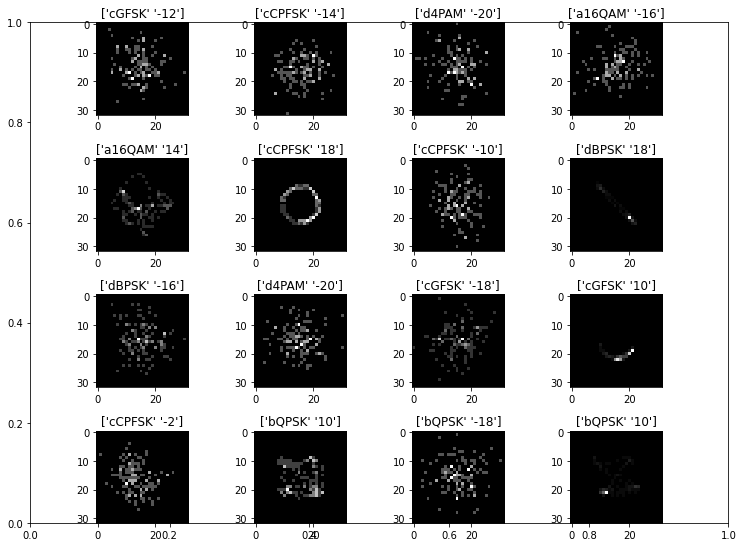

In [ ]:
nbins = 32

fig, ax = plt.subplots(figsize=(10,8)) 
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    counts, xedges, yedges = np.histogram2d(X_train[i][0], X_train[i][1], bins=nbins,range = [[-0.02, 0.02], [-0.02, 0.02]])
    ax.imshow(counts)
    ax.set_title(str(labels_train[i]))
    plt.tight_layout()
plt.show()

32x32 constellation seems to be high enough resolution to capture details and low enough resolution that points are visible and not too sparse. But we do observe some blurring.

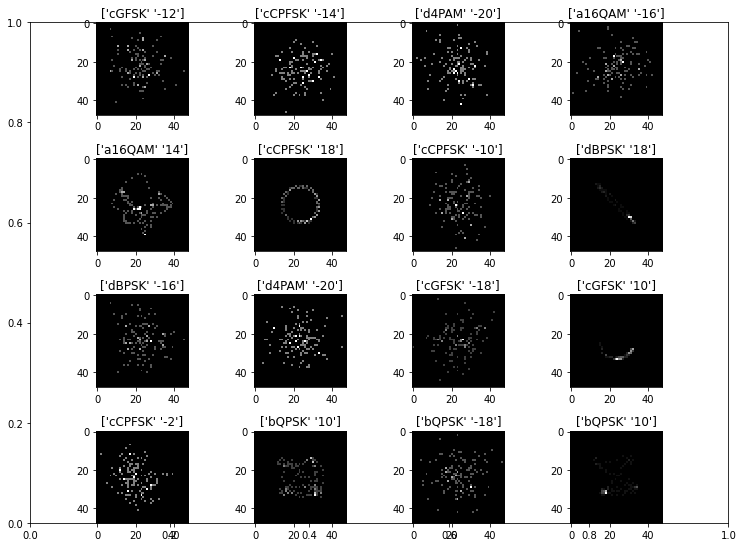

In [ ]:
nbins = 48

fig, ax = plt.subplots(figsize=(10,8)) 
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    counts, xedges, yedges = np.histogram2d(X_train[i][0], X_train[i][1], bins=nbins,range = [[-0.02, 0.02], [-0.02, 0.02]])
    ax.imshow(counts)
    ax.set_title(str(labels_train[i]))
    plt.tight_layout()
plt.show()

48x48 looks better than 32x32, the constellations are not too sparse, and also not too blurred.

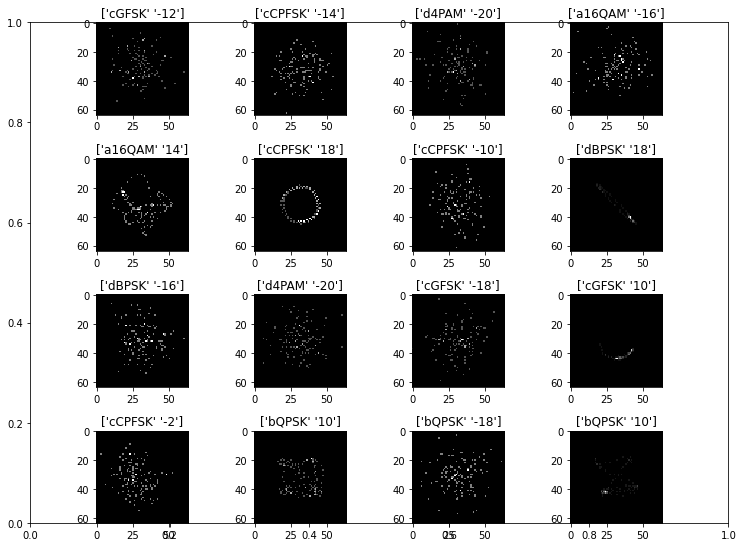

In [ ]:
nbins = 64

fig, ax = plt.subplots(figsize=(10,8)) 
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    counts, xedges, yedges = np.histogram2d(X_train[i][0], X_train[i][1], bins=nbins,range = [[-0.02, 0.02], [-0.02, 0.02]])
    ax.imshow(counts)
    ax.set_title(str(labels_train[i]))
    plt.tight_layout()
plt.show()

Constellations are looking quite sparse already at 64x64.

## Applying colour to constellations

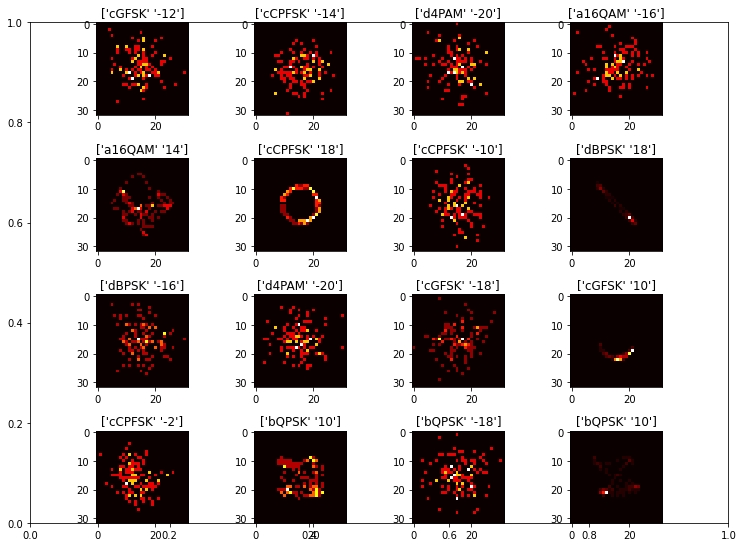

In [ ]:
nbins = 32

fig, ax = plt.subplots(figsize=(10,8)) 
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    counts, xedges, yedges = np.histogram2d(X_train[i][0], X_train[i][1], bins=nbins,range = [[-0.02, 0.02], [-0.02, 0.02]])
    ax.imshow(counts, cmap='hot')
    ax.set_title(str(labels_train[i]))
    plt.tight_layout()
plt.show()

To the human eye, the constellations are definitely clearer now.

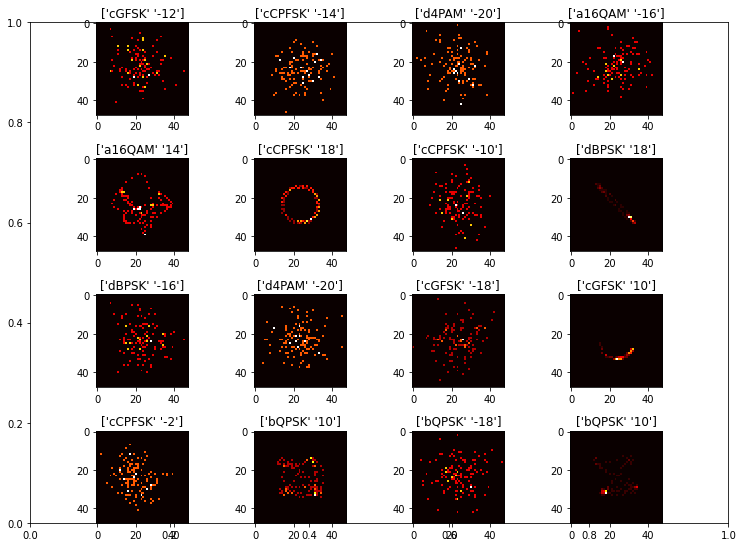

In [ ]:
nbins = 48

fig, ax = plt.subplots(figsize=(10,8)) 
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    counts, xedges, yedges = np.histogram2d(X_train[i][0], X_train[i][1], bins=nbins,range = [[-0.02, 0.02], [-0.02, 0.02]])
    ax.imshow(counts, cmap='hot')
    ax.set_title(str(labels_train[i]))
    plt.tight_layout()
plt.show()

48x48 coloured looks pretty good.

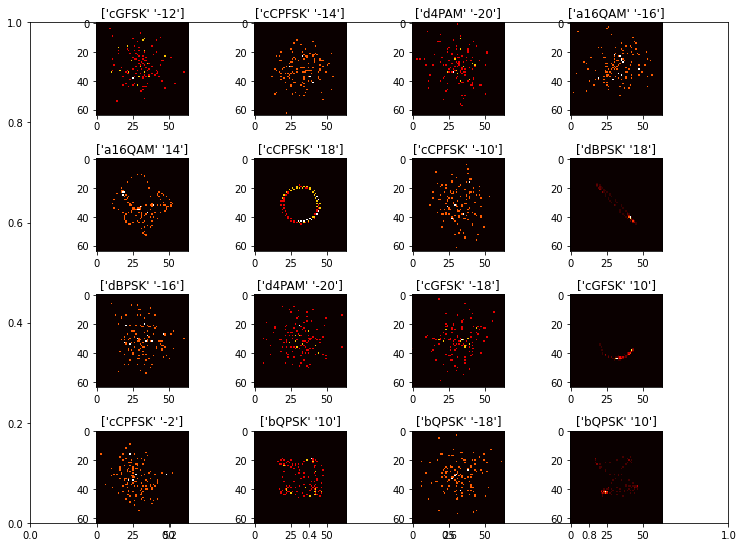

In [ ]:
nbins = 64

fig, ax = plt.subplots(figsize=(10,8)) 
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    counts, xedges, yedges = np.histogram2d(X_train[i][0], X_train[i][1], bins=nbins,range = [[-0.02, 0.02], [-0.02, 0.02]])
    ax.imshow(counts, cmap='hot')
    ax.set_title(str(labels_train[i]))
    plt.tight_layout()
plt.show()

Compared to the grayscale 64x64, the coloured one looks much more distinctive despite having the same resolution still.

## Save 4 constellation types of different dimensions for experimentation 
(1) 32x32x1, (2) 32x32x3, (3) 48x48x1, (4) 48x48x3

I would have tried nbins=64 too but I ran into memory issues because right now I am loading all the data at one shot. It could be circumvented by using Keras' DataGenerator class which allows loading from the directory in batches. But I have problems doing it on Google Colab, because when I tried saving the matrices as images in folders and uploading to Google Drive, the google drive mounting starts cocking up because apparently I have too many files and folders on the drive.

So instead of saving the constellations as individual images, I opted to have them saved as an array of matrices, and saving them into a hdf5 file. But 64x64x3 per data was far too big so I settled for 48x48x3 instead.

Also because of the huge amount of memory taken up by images instead of time-series, I decided to remove low snr data (snr < -10dB) because at such heavy noise conditions, the time-series model were more or less guessing at random anyway (see notebook on time-series_classification). Later I will have a notebook comparing the constellation and time-series model trained on only medium and high snr to be fair.

In [ ]:
from sklearn.externals import joblib
import numpy as np
from matplotlib import pyplot as plt 

root_path = "/content/gdrive/My Drive/mod_rec/"

#function to apply colormap to array and return the array in colour form
def arr2img(arr, chnum):
  norm = plt.Normalize(vmin=arr.min(), vmax=arr.max())
  if chnum == 1:
      cmap = plt.cm.gray
      image4d = cmap(norm(arr)) #RGBA
      img = image4d[:,:,0] #All RGBA channels identical
      
  elif chnum == 3:
      cmap = plt.cm.hot #or can choose any other colormap
      image4d = cmap(norm(arr)) #RGBA
      img = image4d[:,:,:3] #ignore A channel
  
  return img

data = joblib.load(root_path + 'data/rml_trainvaltest.hdf5')

#load data
X_train = data['train']['X']
labels_train = data['train']['labels'] 

X_val = data['val']['X']
labels_val = data['val']['labels'] 

X_test = data['test']['X']
labels_test = data['test']['labels'] 

#only retain data with snr >= -10
snrs = labels_train[:,1]
snrs = np.array([int(snr) for snr in snrs])
idx = np.where(snrs >= -10)
X_train = X_train[idx]
labels_train = labels_train[idx]

snrs = labels_val[:,1]
snrs = np.array([int(snr) for snr in snrs])
idx = np.where(snrs >= -10)
X_val = X_val[idx]
labels_val = labels_val[idx]

snrs = labels_test[:,1]
snrs = np.array([int(snr) for snr in snrs])
idx = np.where(snrs >= -10)
X_test = X_test[idx]
labels_test = labels_test[idx]


nbins = [32, 48]
ch = [1, 3]

for b in nbins:
    for c in ch:
        filename = root_path + 'data/rml_trainvaltest_constel' + str(b) + '_' + str(c) + '.hdf5'
        constel_train = []
        constel_val = []
        constel_test = []

        print(b,c, 'train')
        for i, samp in enumerate(X_train):
            counts, xedges, yedges = np.histogram2d(samp[0], samp[1], bins=b,range = [[-0.02, 0.02], [-0.02, 0.02]])
            img = arr2img(counts, c)
            constel_train.append(img)
        constel_train = np.array(constel_train)

        print(b,c, 'val')
        for i, samp in enumerate(X_val):
            counts, xedges, yedges = np.histogram2d(samp[0], samp[1], bins=b,range = [[-0.02, 0.02], [-0.02, 0.02]])
            img = arr2img(counts, c)
            constel_val.append(img)
        constel_val = np.array(constel_val)

        print(b,c, 'test')
        for i, samp in enumerate(X_test):
            counts, xedges, yedges = np.histogram2d(samp[0], samp[1], bins=b,range = [[-0.02, 0.02], [-0.02, 0.02]])
            img = arr2img(counts, c)
            constel_test.append(img)
        constel_test = np.array(constel_test)

        trainvaltest = {}
        trainvaltest['train'] = {}
        trainvaltest['train']['X'] = constel_train
        trainvaltest['train']['labels'] = labels_train

        trainvaltest['val'] = {}
        trainvaltest['val']['X'] = constel_val
        trainvaltest['val']['labels'] = labels_val

        trainvaltest['test'] = {}
        trainvaltest['test']['X'] = constel_test
        trainvaltest['test']['labels'] = labels_test

        joblib.dump(trainvaltest, filename)

# Load train, val, test constellation data

In [ ]:
from sklearn.externals import joblib
data_constel = joblib.load(root_path + 'data/rml_trainvaltest_constel32_1.hdf5')

In [ ]:
#load data
X_img_train = data_constel['train']['X']
y_img_train = data_constel['train']['labels'][:,0]
labels_img_train = data_constel['train']['labels'] 

X_img_val = data_constel['val']['X']
y_img_val = data_constel['val']['labels'][:,0]
labels_img_val = data_constel['val']['labels'] 

X_img_test = data_constel['test']['X']
y_img_test = data_constel['test']['labels'][:,0]
labels_img_test = data_constel['test']['labels'] 

In [ ]:
del data_constel

In [ ]:
nbins = X_img_train.shape[1]
c = 1
X_img_train = X_img_train.reshape(-1, nbins, nbins, c)
X_img_val = X_img_val.reshape(-1, nbins, nbins, c)
X_img_test = X_img_test.reshape(-1, nbins, nbins, c)

# Training constellation model

Classifying by coloured constellation images have shown great accuracy in: [Data-Driven Deep Learning for Automatic Modulation Recognition in Cognitive Radios](https://ieeexplore.ieee.org/document/8645696). From human eye, we are able to recognise the modulation from the I/Q constellation at high SNR, and presumably a CNN would be able to do the same as it has been proven to work well on image classification. 

I only trained with data of SNR >= -10dB because the images take up quite a bit of memory and I wanted to speed up training, plus I assumed that low SNR samples are too noisy anyway so it might be better to just use cleaner samples for training.

# Model architecture of constellation classifier

From: [Data-Driven Deep Learning for Automatic Modulation Recognition in Cognitive Radios](https://ieeexplore.ieee.org/document/8645696) 

This model consists of five convolutional layers and three dense layers, similar to a standard AlexNet. 

In [ ]:
def build_constellation_net(X1, X2, X3):
  model = Sequential()
  model.add(Reshape((X1, X2, X3), input_shape=(X1, X2, X3)))
  model.add(Conv2D(128, (5,5), padding='valid', data_format="channels_last"))
  model.add(PReLU(alpha_initializer=Constant(value=0.25)))
  model.add(AveragePooling2D(pool_size=(2, 2), strides=2))
  model.add(Conv2D(64, (3,3), padding='same'))
  model.add(PReLU(alpha_initializer=Constant(value=0.25)))
  model.add(Conv2D(64, (3,3), padding='same'))
  model.add(PReLU(alpha_initializer=Constant(value=0.25)))
  model.add(AveragePooling2D(pool_size=(2, 2), strides=2))
  model.add(Conv2D(32, (3,3), padding='same'))
  model.add(PReLU(alpha_initializer=Constant(value=0.25)))  
  model.add(Conv2D(32, (3,3), padding='same'))
  model.add(PReLU(alpha_initializer=Constant(value=0.25)))
  model.add(AveragePooling2D(pool_size=(2, 2), strides=2))
  model.add(Flatten())
  model.add(Dense(1024))
  model.add(PReLU(alpha_initializer=Constant(value=0.25)))
  model.add(Dropout(0.5))
  model.add(Dense(512))
  model.add(PReLU(alpha_initializer=Constant(value=0.25)))
  model.add(Dropout(0.5))
  model.add(Dense(NUM_CLASSES, activation='softmax'))
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) #smaller loss better for images
  model.summary()
  return model

## Training on 32x32x1 constellations

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 128)       3328      
_________________________________________________________________
p_re_lu_8 (PReLU)            (None, 28, 28, 128)       100352    
_________________________________________________________________
average_pooling2d_4 (Average (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
p_re_lu_9 (PReLU)            (None, 14, 14, 64)        12544     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 64)       

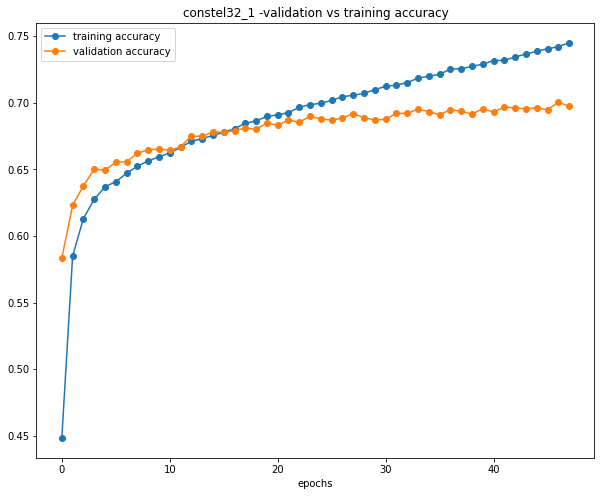

None

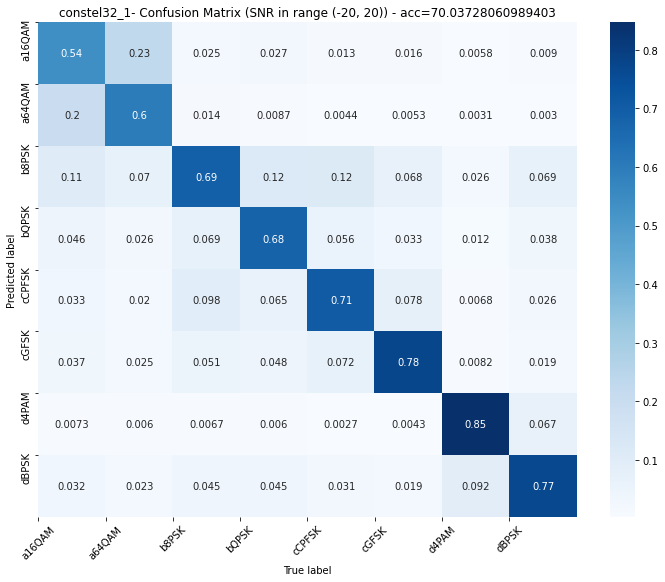

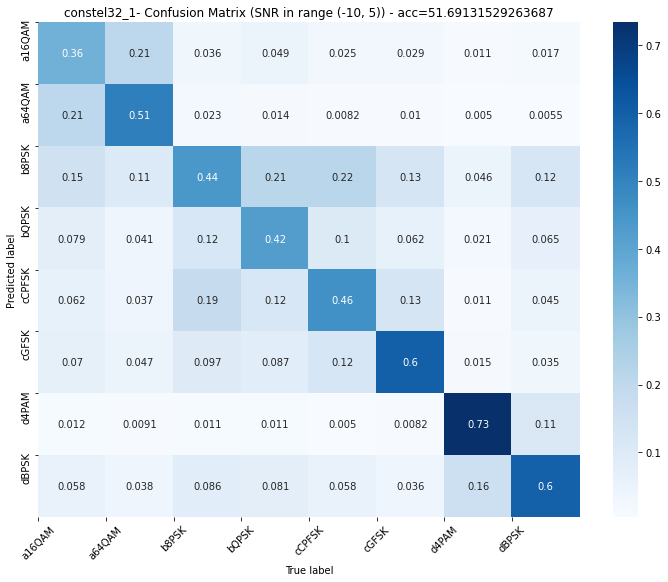

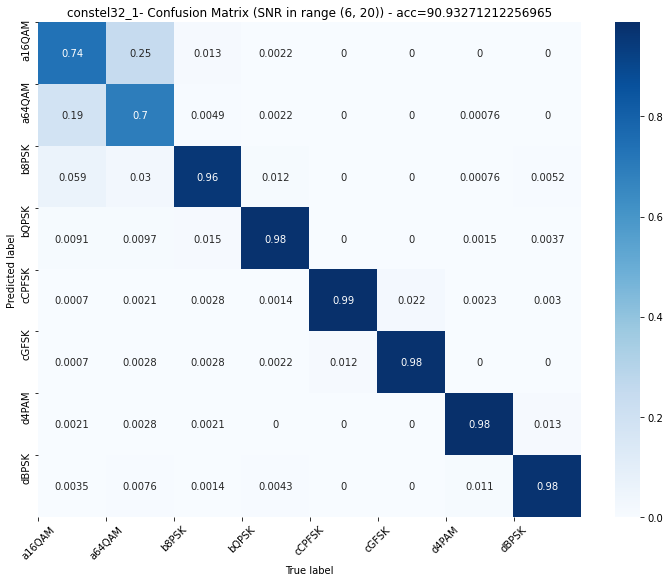

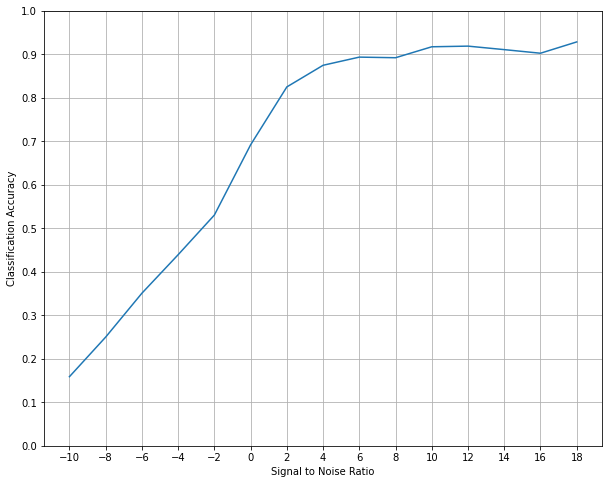

In [ ]:
constellation_32_1_model = build_constellation_net(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3])
constellation_32_1_model_evaluater = ModelEvaluater(constellation_32_1_model, X_img_train, y_img_train, X_img_val, y_img_val, X_img_test, y_img_test, labels_img_test, BATCH_SIZE, 'constel32_1' )
constellation_32_1_model_evaluater.fit(EPOCHS,patience=PATIENCE)
constellation_32_1_model_evaluater.print_summary()

This performance is a good start, again there is difficulty differentiating QAMs. Not sure if the first layer's 5x5 filter might be too big considering that the input image size is only 32x32, but I am just copying the model architecture used in the paper, so architecure has not been optimised yet.

## Training on 48x48x1 constellations

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 44, 44, 128)       3328      
_________________________________________________________________
p_re_lu_22 (PReLU)           (None, 44, 44, 128)       247808    
_________________________________________________________________
average_pooling2d_10 (Averag (None, 22, 22, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 22, 22, 64)        73792     
_________________________________________________________________
p_re_lu_23 (PReLU)           (None, 22, 22, 64)        30976     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 22, 22, 64)       

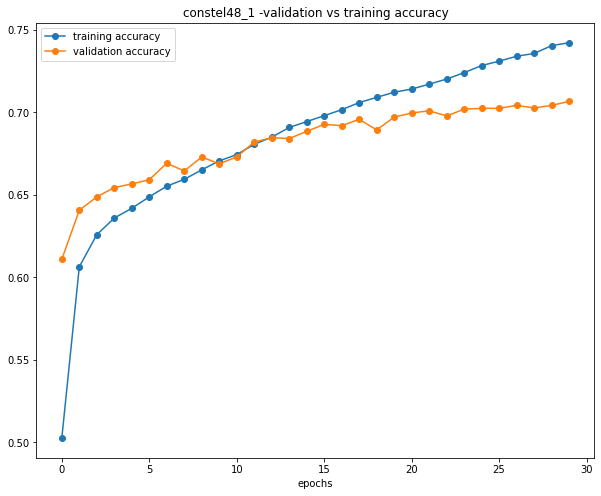

None

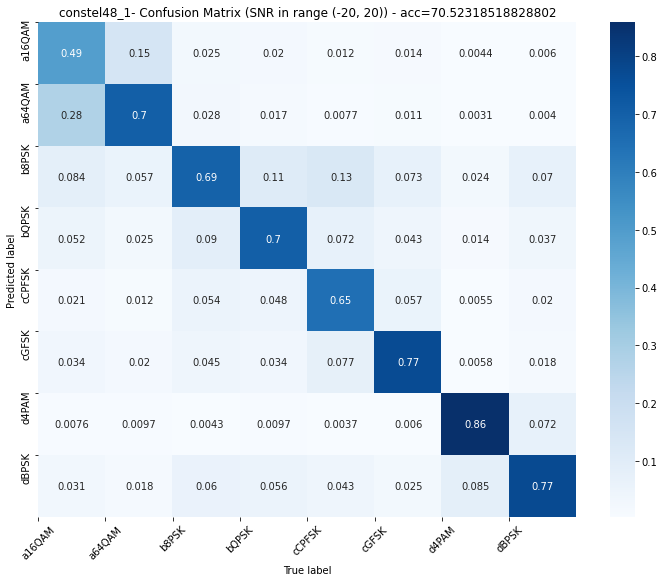

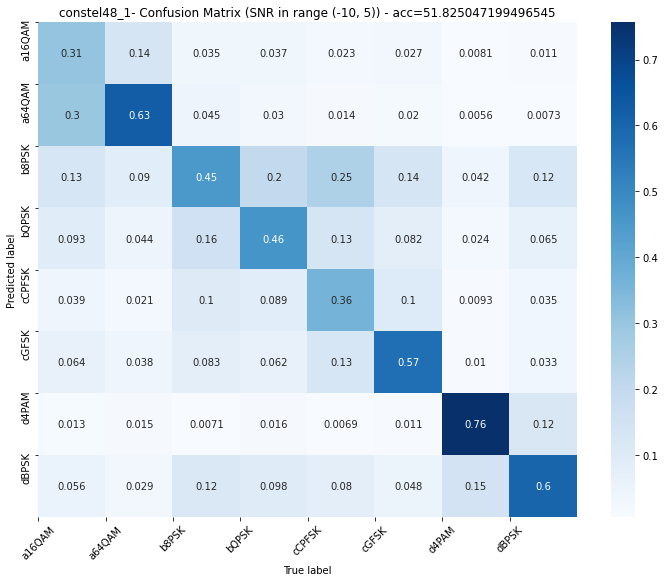

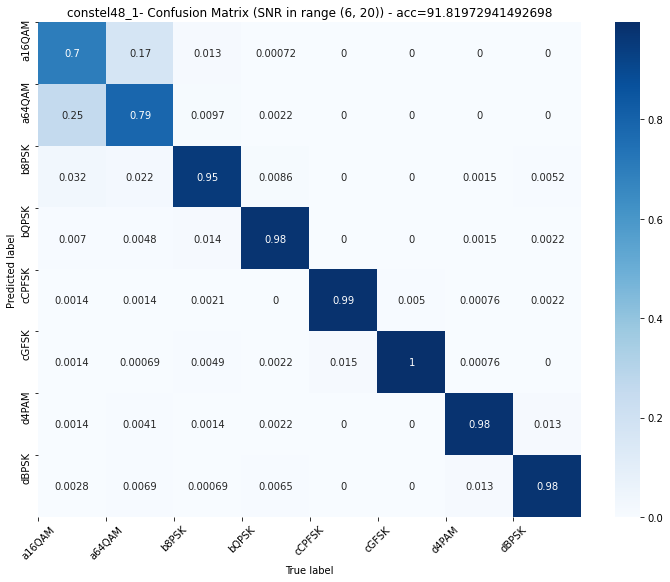

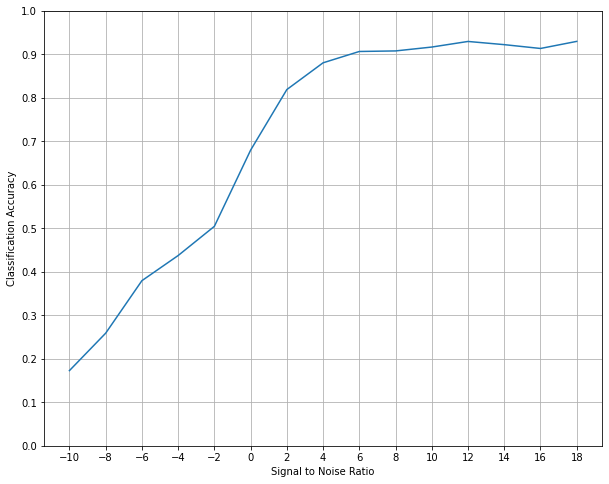

In [ ]:
constellation_48_1_model = build_constellation_net(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3])
constellation_48_1_model_evaluater = ModelEvaluater(constellation_48_1_model, X_img_train, y_img_train, X_img_val, y_img_val, X_img_test, y_img_test, labels_img_test, BATCH_SIZE, 'constel48_1' )
constellation_48_1_model_evaluater.fit(EPOCHS,patience=PATIENCE)
constellation_48_1_model_evaluater.print_summary()

48x48x1 only has slight improvement over 32x32x1. Perhaps this suggest 32 is a pretty good resolution already.

## Training on 32x32x3 constellations

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 128)       9728      
_________________________________________________________________
p_re_lu_29 (PReLU)           (None, 28, 28, 128)       100352    
_________________________________________________________________
average_pooling2d_13 (Averag (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 14, 14, 64)        73792     
_________________________________________________________________
p_re_lu_30 (PReLU)           (None, 14, 14, 64)        12544     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 64)       

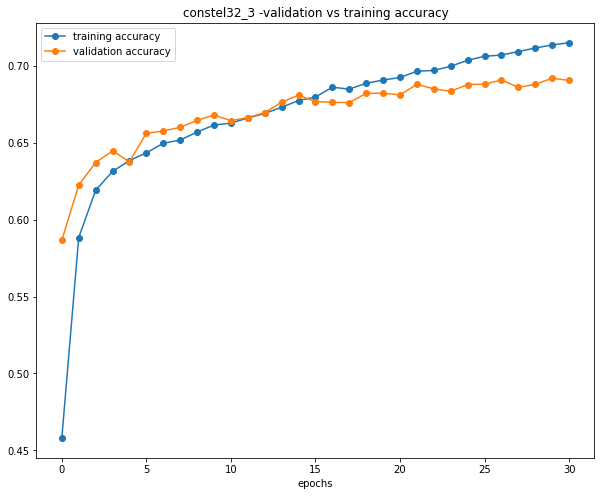

None

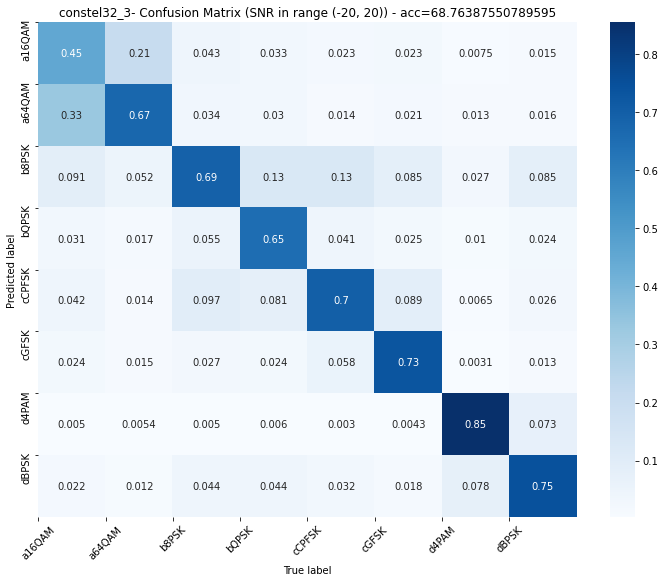

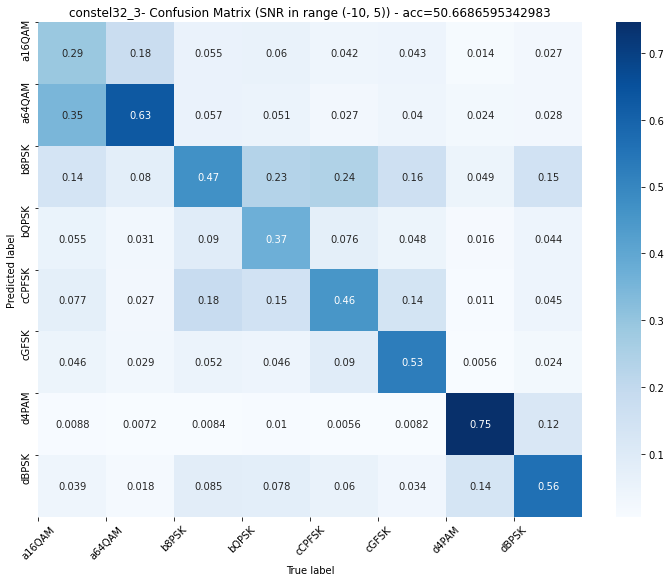

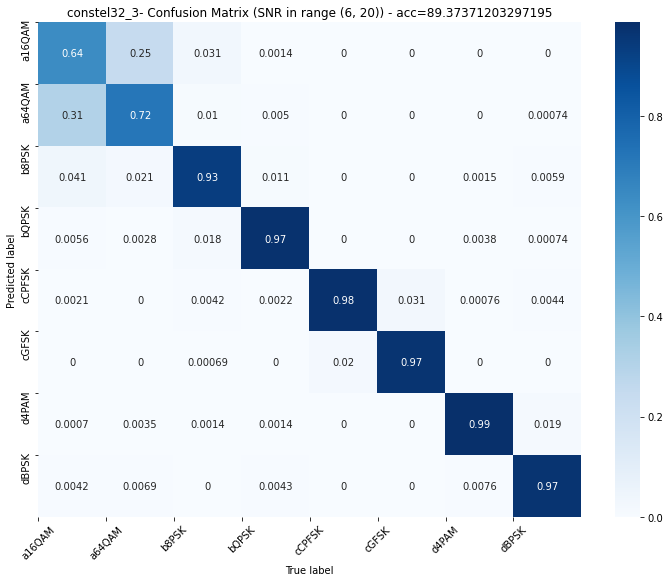

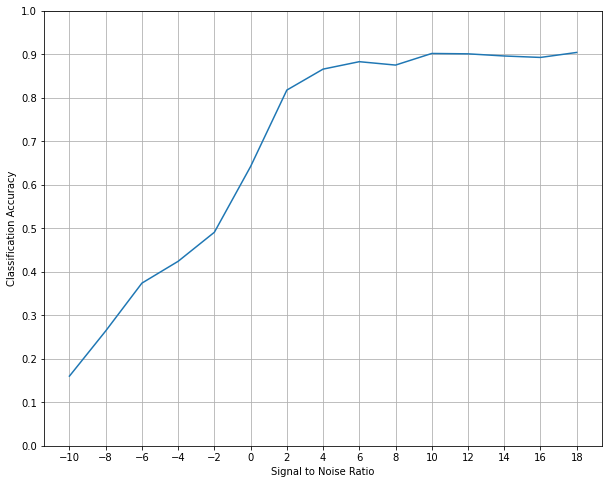

In [ ]:
constellation_32_3_model = build_constellation_net(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3])
constellation_32_3_model_evaluater = ModelEvaluater(constellation_32_3_model, X_img_train, y_img_train, X_img_val, y_img_val, X_img_test, y_img_test, labels_img_test, BATCH_SIZE, 'constel32_3' )
constellation_32_3_model_evaluater.fit(EPOCHS,patience=PATIENCE)
constellation_32_3_model_evaluater.print_summary()

The coloured version actually performed worse than the grayscale version with dimension 32x32x1. This is surprising and different from what was discovered in the paper.

## Training on 48x48x3 constellations

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 48, 48, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 128)       9728      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 44, 44, 128)       247808    
_________________________________________________________________
average_pooling2d_1 (Average (None, 22, 22, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        73792     
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 22, 22, 64)        30976     
______________________________________

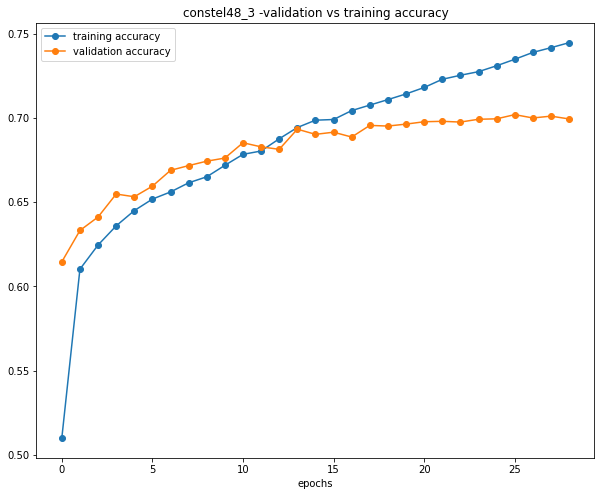

None

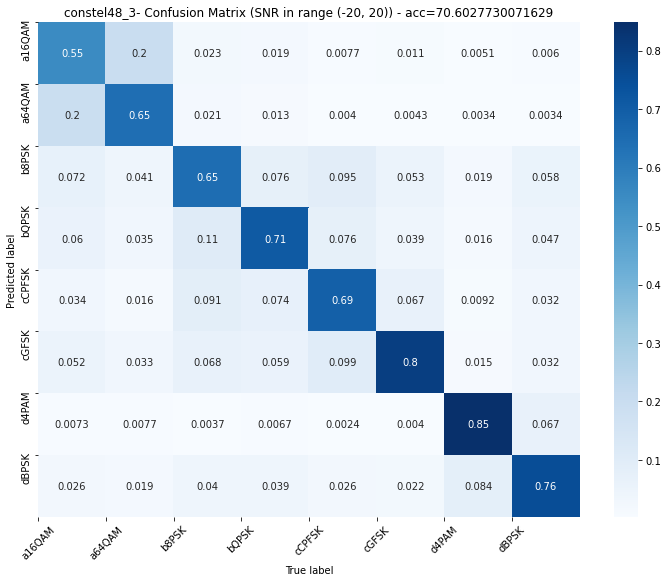

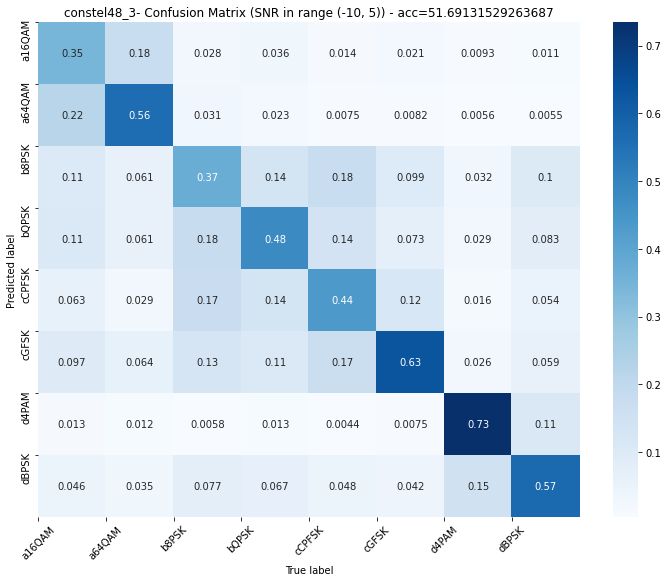

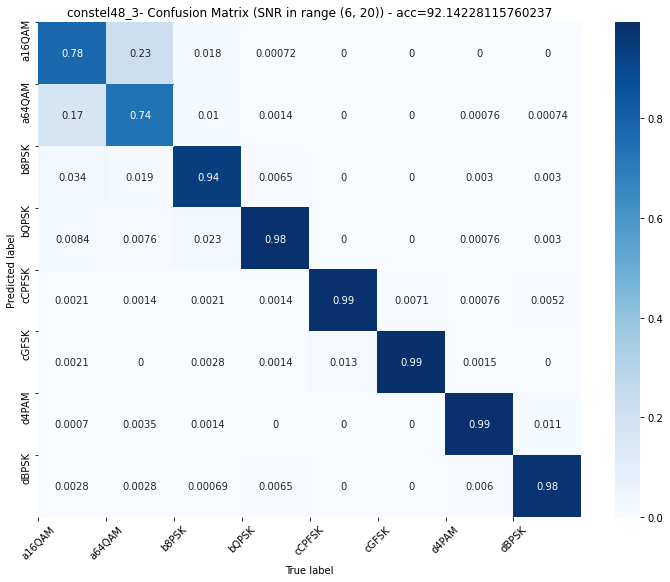

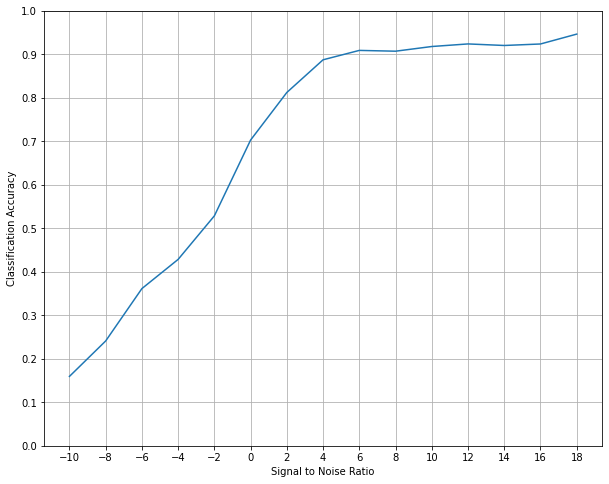

In [ ]:
constellation_48_3_model = build_constellation_net(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3])
constellation_48_3_model_evaluater = ModelEvaluater(constellation_48_3_model, X_img_train, y_img_train, X_img_val, y_img_val, X_img_test, y_img_test, labels_img_test, BATCH_SIZE, 'constel48_3' )
constellation_48_3_model_evaluater.fit(EPOCHS,patience=PATIENCE)
constellation_48_3_model_evaluater.print_summary()

Slight improvement over 48x48x1. Seems like colour really don't have that great of an impact.

# Insights and conclusion
Here, we do an overall comparison and conclude which is the best resolution and colouration.

In [ ]:
from sklearn.externals import joblib
data_constel = joblib.load(root_path + 'data/rml_trainvaltest_constel48_3.hdf5')

X_img_483 = data_constel['test']['X']
labels_img = data_constel['test']['labels']
y_img = labels_img[:,0]
X_img_483 = X_img_483.reshape(-1, 48, 48, 3)

del data_constel

data_constel = joblib.load(root_path + 'data/rml_trainvaltest_constel48_1.hdf5')
X_img_481 = data_constel['test']['X']
X_img_481 = X_img_481.reshape(-1, 48, 48, 1)
del data_constel

data_constel = joblib.load(root_path + 'data/rml_trainvaltest_constel32_3.hdf5')
X_img_323 = data_constel['test']['X']
X_img_323 = X_img_323.reshape(-1, 32, 32, 3)
del data_constel

data_constel = joblib.load(root_path + 'data/rml_trainvaltest_constel32_1.hdf5')
X_img_321 = data_constel['test']['X']
X_img_321 = X_img_321.reshape(-1, 32, 32, 1)
del data_constel

In [ ]:
constellation_32_1_model = build_constellation_net(X_img_321.shape[1], X_img_321.shape[2], X_img_321.shape[3])
constellation_32_1_model.load_weights(root_path + 'constel32_1-weights-38.hdf5')
constellation_32_1_model_evaluater = ModelEvaluater(constellation_32_1_model, X_img_321, y_img, X_img_321, y_img, X_img_321, y_img, labels_img, BATCH_SIZE, 'constel32_1' )
acc321 = constellation_32_1_model_evaluater.accpersnr_model()

constellation_32_3_model = build_constellation_net(X_img_323.shape[1], X_img_323.shape[2], X_img_323.shape[3])
constellation_32_3_model.load_weights(root_path + 'constel32_3-weights-27.hdf5')
constellation_32_3_model_evaluater = ModelEvaluater(constellation_32_3_model, X_img_323, y_img, X_img_323, y_img, X_img_323, y_img, labels_img, BATCH_SIZE, 'constel32_3' )
acc323 = constellation_32_3_model_evaluater.accpersnr_model()

constellation_48_1_model = build_constellation_net(X_img_481.shape[1], X_img_481.shape[2], X_img_481.shape[3])
constellation_48_1_model.load_weights(root_path + 'constel48_1-weights-26.hdf5')
constellation_48_1_model_evaluater = ModelEvaluater(constellation_48_1_model, X_img_481, y_img, X_img_481, y_img, X_img_481, y_img, labels_img, BATCH_SIZE, 'constel48_1' )
acc481 = constellation_48_1_model_evaluater.accpersnr_model()

constellation_48_3_model = build_constellation_net(X_img_483.shape[1], X_img_483.shape[2], X_img_483.shape[3])
constellation_48_3_model.load_weights(root_path + 'constel48_3-weights-25.hdf5')
constellation_48_3_model_evaluater = ModelEvaluater(constellation_48_3_model, X_img_483, y_img, X_img_483, y_img, X_img_483, y_img, labels_img, BATCH_SIZE, 'constel48_3' )
acc483 = constellation_48_3_model_evaluater.accpersnr_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       3328      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 28, 28, 128)       100352    
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 14, 14, 64)        12544     
______________________________________

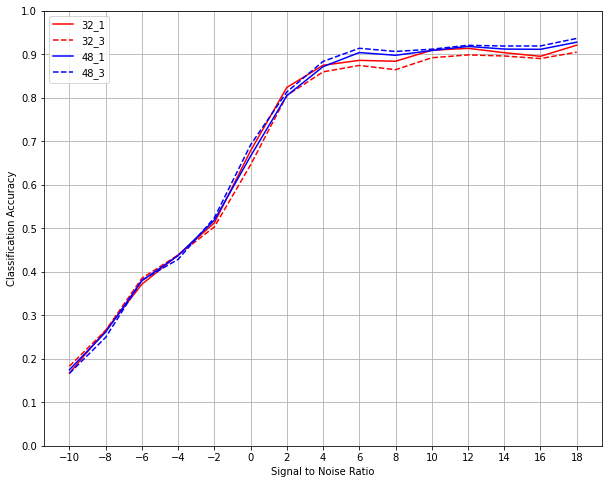

In [ ]:
# plot acc-vs-snr graphs for different models
_acc321,  = plt.plot(list(acc321.keys()),list(acc321.values()), 'r-', label='32_1')
_acc323,  = plt.plot(list(acc323.keys()),list(acc323.values()), 'r--', label='32_3')
_acc481,  = plt.plot(list(acc481.keys()),list(acc481.values()), 'b-', label='48_1')
_acc483,  = plt.plot(list(acc483.keys()),list(acc483.values()), 'b--', label='48_3')

plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.xticks(list(acc321.keys()))
plt.legend(handles = [_acc321, _acc323, _acc481, _acc483])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True)
plt.show()

## Effect of resolution

32 and 48 are quite close in resolution, and we do see 48 performing better than 32. I think even higher resolution like 64 and 96 will also perform even better.


## Effect of colouration
However, what is surprising is that colouration does not help at all, contrary to what was presented in the paper.Perhaps also because of hyperparameter tuning, plus I only tried one model architecture, and also the small number of data points. 



## Other comments
Confusion matrices wise all performed similarly, with slight confusion between QAMs.

## Further action on insights
I wanted to check if it is possible to distinguish between QAMs when resolution is high enough, because for 32 and 48 it wasn't sufficient. 

### Load QAM train, val, test constellation data

In [ ]:
from sklearn.externals import joblib
data_constel = joblib.load(root_path + 'data/rmlQAM_trainvaltest_constel96_1.hdf5')

In [ ]:
#load data
X_img_train = data_constel['train']['X']
y_img_train = data_constel['train']['labels'][:,0]
labels_img_train = data_constel['train']['labels'] 

X_img_val = data_constel['val']['X']
y_img_val = data_constel['val']['labels'][:,0]
labels_img_val = data_constel['val']['labels'] 

X_img_test = data_constel['test']['X']
y_img_test = data_constel['test']['labels'][:,0]
labels_img_test = data_constel['test']['labels'] 

In [ ]:
del data_constel

In [ ]:
NUM_CLASSES = np.unique(y_img_test).shape[0]
nbins = X_img_train.shape[1]
c = 1
X_img_train = X_img_train.reshape(-1, nbins, nbins, c)
X_img_val = X_img_val.reshape(-1, nbins, nbins, c)
X_img_test = X_img_test.reshape(-1, nbins, nbins, c)

### Training on 64x64x1 constellations for QAMs only

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_16 (Reshape)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 60, 60, 128)       3328      
_________________________________________________________________
p_re_lu_106 (PReLU)          (None, 60, 60, 128)       460800    
_________________________________________________________________
average_pooling2d_46 (Averag (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 30, 30, 64)        73792     
_________________________________________________________________
p_re_lu_107 (PReLU)          (None, 30, 30, 64)        57600     
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 30, 30, 64)      

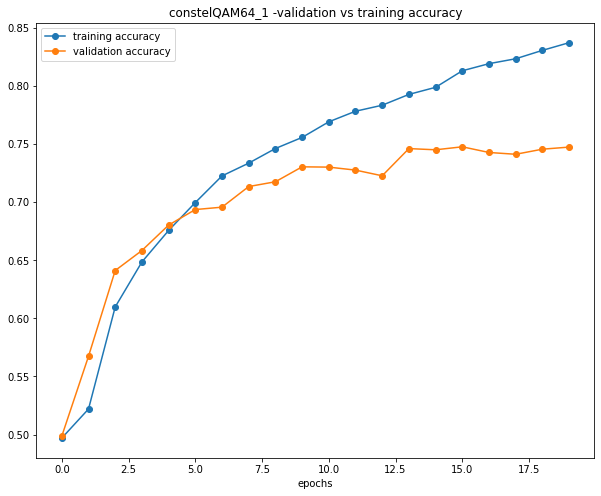

None

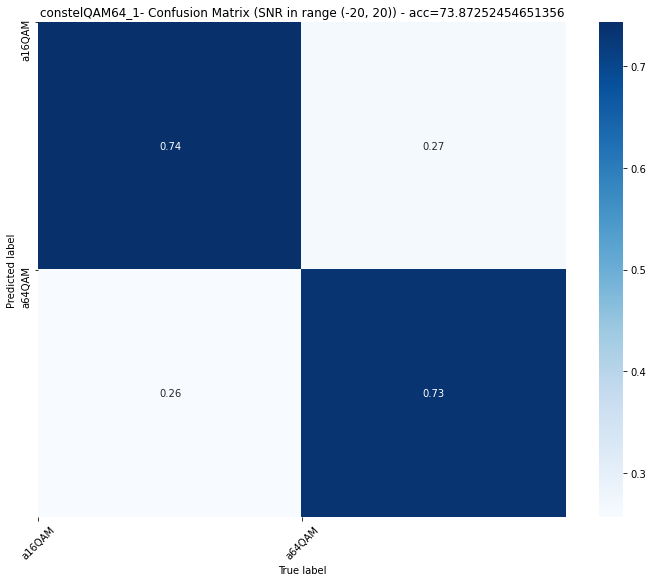

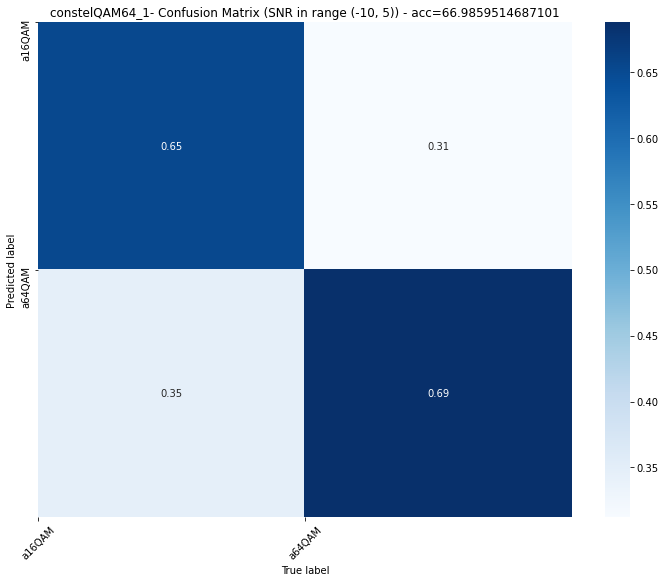

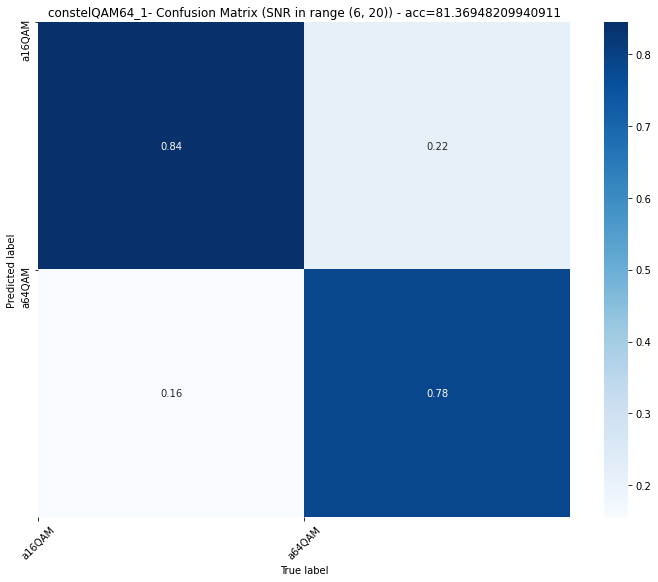

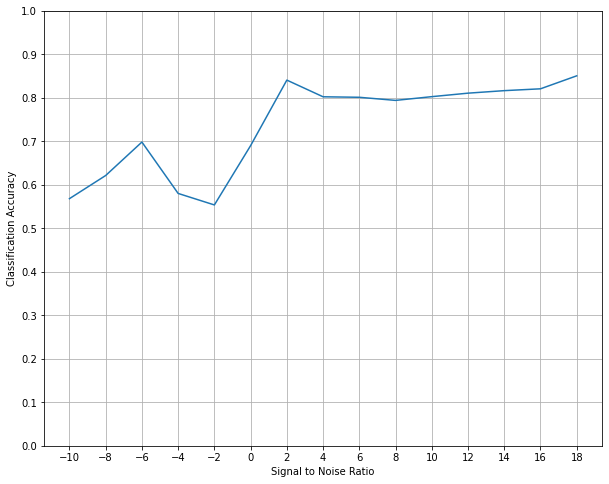

In [ ]:
constellationQAM_64_1_model = build_constellation_net(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3])
constellationQAM_64_1_model_evaluater = ModelEvaluater(constellationQAM_64_1_model, X_img_train, y_img_train, X_img_val, y_img_val, X_img_test, y_img_test, labels_img_test, BATCH_SIZE, 'constelQAM64_1' )
constellationQAM_64_1_model_evaluater.fit(EPOCHS,patience=PATIENCE)
constellationQAM_64_1_model_evaluater.print_summary()

Higher resolution of 64 increases discernability of QAMs by about 6% compared to resolution of 32, 48.

### Training on 64x64x3 constellations for QAMs only

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 128)       9728      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 60, 60, 128)       460800    
_________________________________________________________________
average_pooling2d_1 (Average (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        73792     
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 30, 30, 64)        57600     
______________________________________

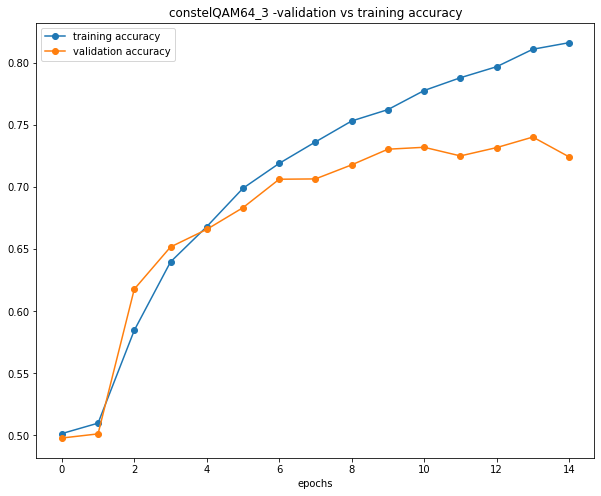

None

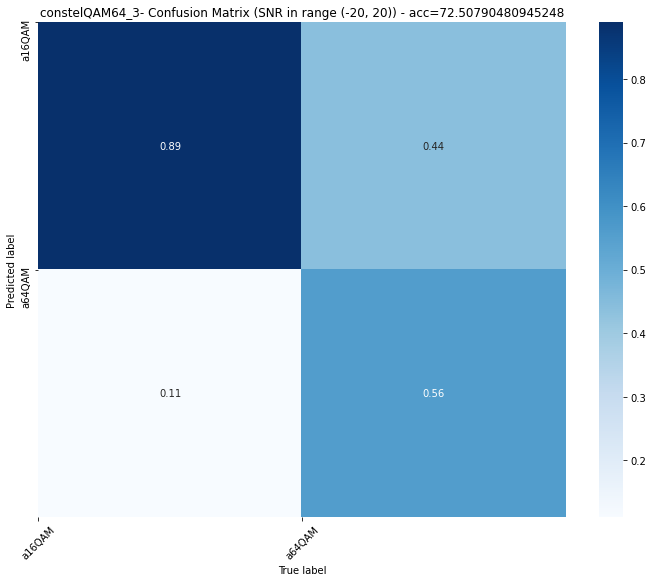

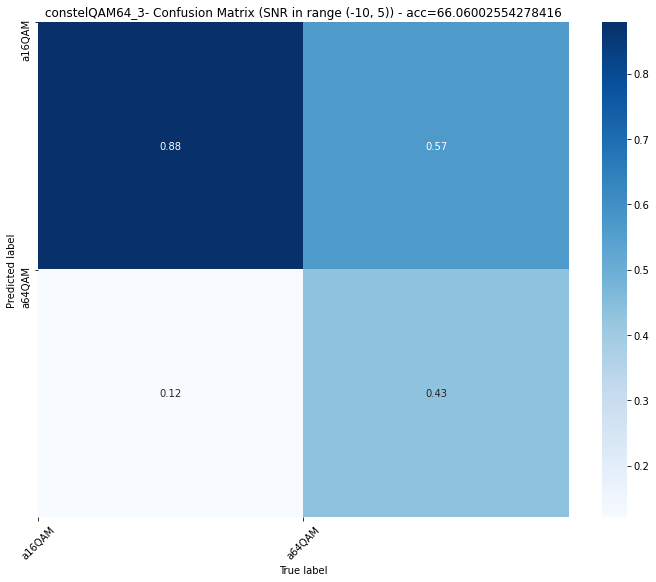

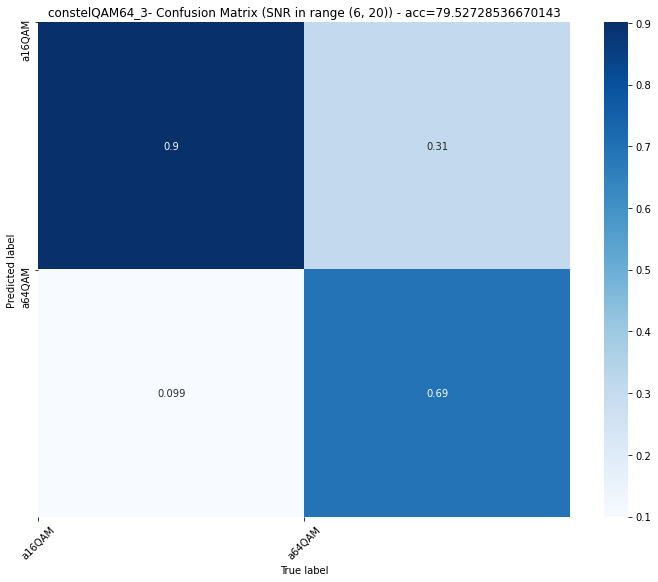

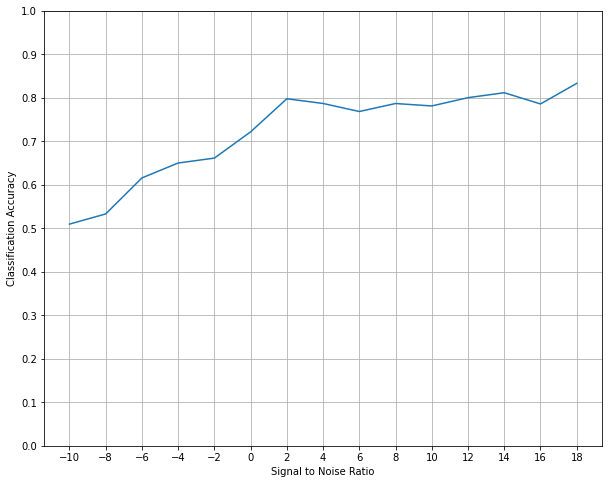

In [ ]:
constellationQAM_64_3_model = build_constellation_net(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3])
constellationQAM_64_3_model_evaluater = ModelEvaluater(constellationQAM_64_3_model, X_img_train, y_img_train, X_img_val, y_img_val, X_img_test, y_img_test, labels_img_test, BATCH_SIZE, 'constelQAM64_3' )
constellationQAM_64_3_model_evaluater.fit(EPOCHS,patience=PATIENCE)
constellationQAM_64_3_model_evaluater.print_summary()

Again, colouration doesn't seem to help at all.

### Training on 96x96x1 constellations for QAMs only

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_18 (Reshape)         (None, 96, 96, 1)         0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 92, 92, 128)       3328      
_________________________________________________________________
p_re_lu_120 (PReLU)          (None, 92, 92, 128)       1083392   
_________________________________________________________________
average_pooling2d_52 (Averag (None, 46, 46, 128)       0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 46, 46, 64)        73792     
_________________________________________________________________
p_re_lu_121 (PReLU)          (None, 46, 46, 64)        135424    
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 46, 46, 64)      

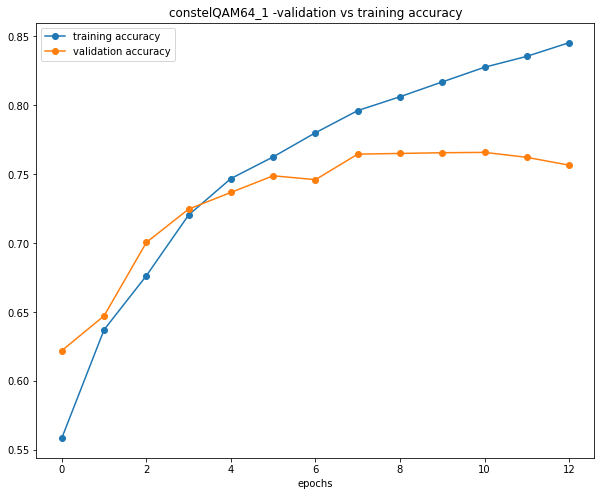

None

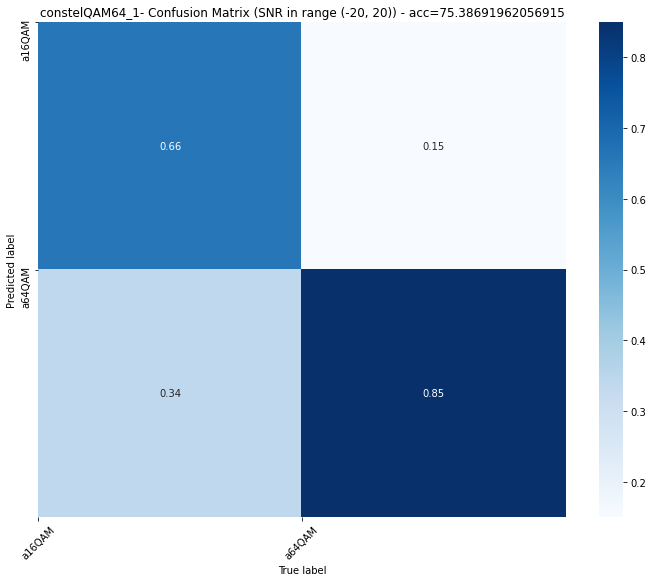

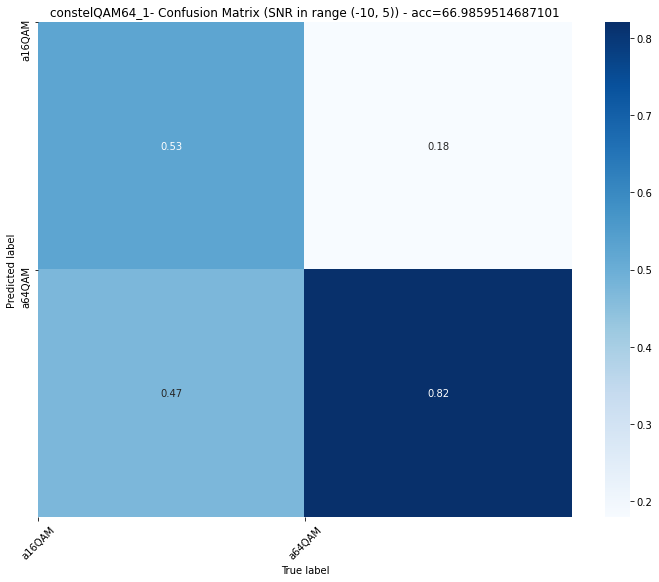

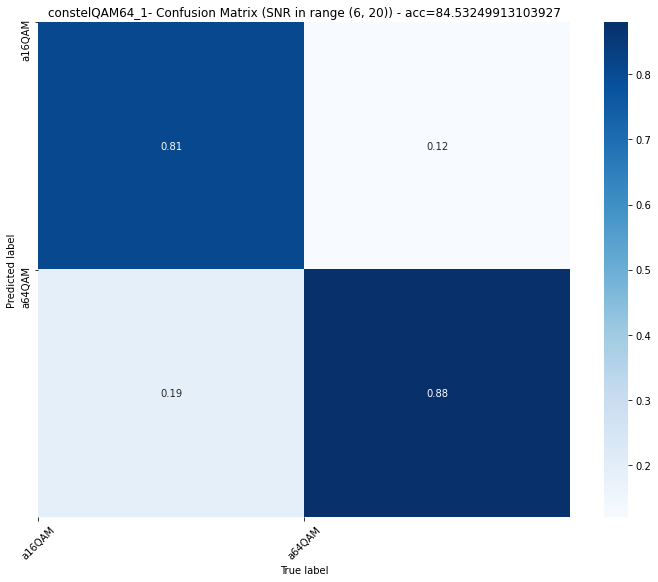

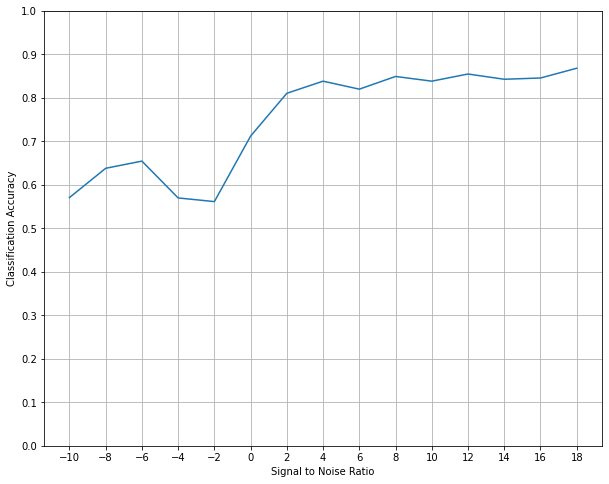

In [ ]:
constellationQAM_96_1_model = build_constellation_net(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3])
constellationQAM_96_1_model_evaluater = ModelEvaluater(constellationQAM_96_1_model, X_img_train, y_img_train, X_img_val, y_img_val, X_img_test, y_img_test, labels_img_test, BATCH_SIZE, 'constelQAM64_1' )
constellationQAM_96_1_model_evaluater.fit(EPOCHS,patience=PATIENCE)
constellationQAM_96_1_model_evaluater.print_summary()

Resolution of 96 performs even better than 64 at high SNR, but deteriorates for medium SNR.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 96, 96, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 128)       3328      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 92, 92, 128)       1083392   
_________________________________________________________________
average_pooling2d_1 (Average (None, 46, 46, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        73792     
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 46, 46, 64)        135424    
______________________________________

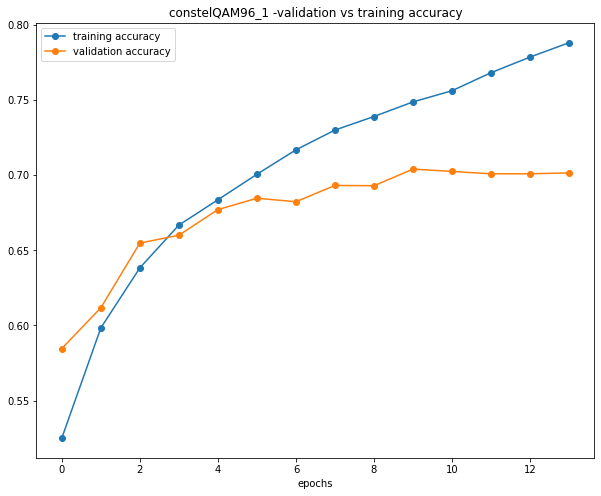

None

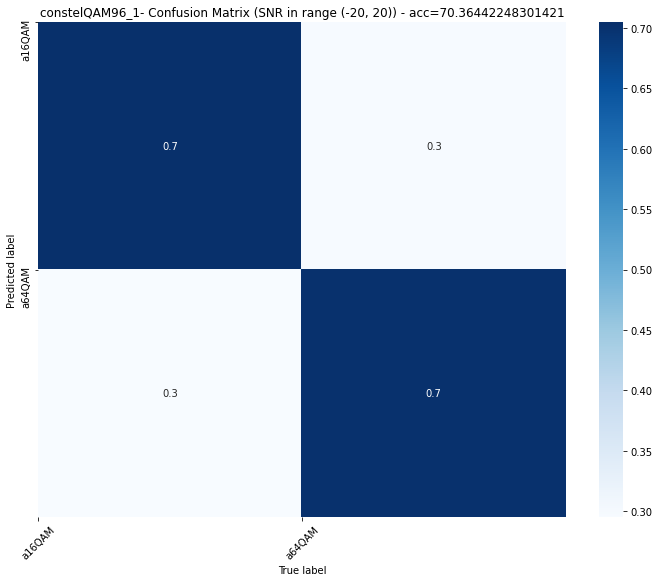

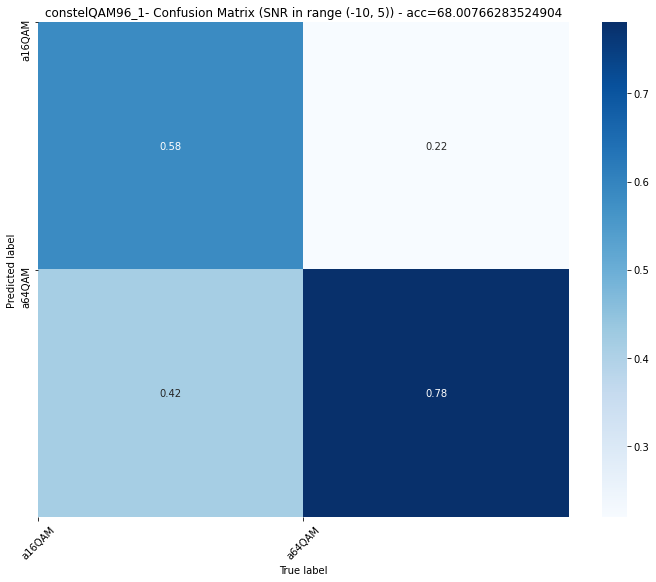

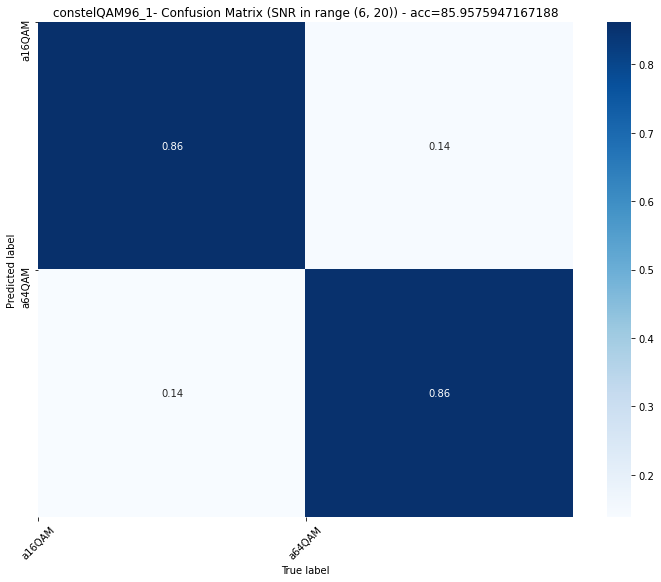

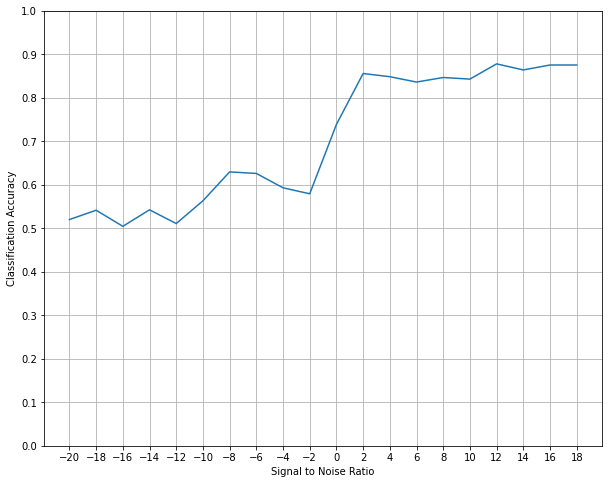

In [ ]:
constellationQAM_96_1_model = build_constellation_net(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3])
constellationQAM_96_1_model_evaluater = ModelEvaluater(constellationQAM_96_1_model, X_img_train, y_img_train, X_img_val, y_img_val, X_img_test, y_img_test, labels_img_test, BATCH_SIZE, 'constelQAM96_1' )
constellationQAM_96_1_model_evaluater.fit(EPOCHS,patience=PATIENCE)
constellationQAM_96_1_model_evaluater.print_summary()

### Comments
Indeed, the higher the resolution the better the distinguishability, but at resolution= 96, I still haven't hit 90% accuracy. I suspect the greatest limiting factor is the number of data points, 128 points means only 16 symbols which is probably too few.